# 7章

### メモ

CNNについて。

画像処理のフィルターを掛けていくネットワークを作って
フィルターをパラメータとして学習させることで、画像の元の形状をネットワークに流すという発想。

0埋めのパディングなどがよく使われる。

畳み込み演算とパディングまでは知っている内容だったりしたけれどもストライドというのは新しいな。
ストライドはずらす量のことか。

入旅行サイズとパディングストライドフィルターサイズの関係式が出てきた。
まあ、これはたしかにこうなるよねとしか。
きちんと割り切れるようにする必要があると。

画像データは縦横の他にrgbなどのチャンネルがあるので3次元データになる。
フィルターも各チャンネルに用意して三次元のカーネルにする。

チャンネルも合わせて積和演算する。
チャンネル方向が削減されてしまうので、適当なN個のフィルタを用意して
出力データをブロックの形にすると。
なのでフィルタの個数まで考慮してやる必要があるということになる。
出力のチャンネル数はrgb3チャンネルである必要はないので適当に20チャンネルとかにもできる。
バイアスはフィルタごとにひとつずつもたせるのでフィルタの数、出力のチャンネル数と同じだけの
バイアスを持つことになる。

バッチ処理をするとなると四次元のデータが流れることになる。

プーリング層は空間を小さくする演算。
普通はプーリングのウィンドウサイズとストライドに同じ値をとる。

画像処理の分野においては主にMaxプーリングが使われていると。

プーリング層は学習するパラメータがない。
また空間を小さくするのは幅と高さの方向だけでチャンネル数は変化しない。

何も考えずに実装すると4次元のデータに対してfor文が多重に含まれることになり面倒で速度的にもマイナス。

im2colという関数を使うと入力データをフィルタが扱いやすいように展開してくれるらしい。
フィルターの適用領域ごとに展開してくれる。
フィルターが重なっている部分が展開されるのでメモリ使用量は増えることになるがまとめて計算が行いやすくなる。

フィルタ一つの領域を横一列に並べてくれると、フィルタを縦一列にすれば行列の積で一気に計算ができると。

## Convolution/Poolingレイヤの実装

### Convolutionレイヤの実装

im2colで一つのフィルタ領域を横一列に引き伸ばした行列にしてくれる。フィルタの方を縦一列にしておけば積和演算は行列の積で計算できる。頭良いな。

`im2col`関数を試してみる。

In [1]:
import numpy as np

In [2]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

バッチ数が1でチャンネル数がrgb3チャネル、大きさが7x7とする。
これを5x5のフィルタでstride=1でpad=0で試してみる。
フィルタは7x7のなかを5x5を入れていきpadが0なので

```
*-*-*-*-*-*-*-*
|#|#|#|#|#| | |
*-*-*-*-*-*-*-*
|#|#|#|#|#| | |
*-*-*-*-*-*-*-*
|#|#|#|#|#| | |
*-*-*-*-*-*-*-*
|#|#|#|#|#| | |
*-*-*-*-*-*-*-*
|#|#|#|#|#| | |
*-*-*-*-*-*-*-*
| | | | | | | |
*-*-*-*-*-*-*-*
| | | | | | | |
*-*-*-*-*-*-*-*
```

9回のフィルタ処理が行われることになる。一回のフィルタ処理は5x5が3チャンネル分なので75個の積和演算になる。

In [3]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(9, 75)


確かに9x75の行列に展開されている。

バッチ数を10に増やしてみると、やらねばならないフィルタ処理は10倍になる。

In [4]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


確かに90x75の行列になった。

---

`im2col`を使って畳み込み層を実装する。

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### Poolingレイヤの実装

In [6]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## CNNの実装

In [7]:
import pickle
from collections import OrderedDict
from common.layers import *

In [8]:
class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

実際に学習させていく。

In [9]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

train loss:2.300176200608215
=== epoch:1, train acc:0.349, test acc:0.335 ===
train loss:2.298077624815343
train loss:2.293482911795813
train loss:2.288146286882419
train loss:2.280447127172821
train loss:2.2667121323820907
train loss:2.249761758262464
train loss:2.230158345335212
train loss:2.213778007976242
train loss:2.1938134885879794
train loss:2.157398871069123
train loss:2.1117448389581694
train loss:2.046926907467229
train loss:2.017178651927389
train loss:1.978029746281851
train loss:1.8848267151531142
train loss:1.8569972089556135
train loss:1.7282079254130218
train loss:1.7808629269024305
train loss:1.6772571850675337
train loss:1.541062010340407
train loss:1.4632388568022252
train loss:1.3860887808027311
train loss:1.3076218144828702
train loss:1.2521657627365312
train loss:1.1221765452053023
train loss:1.1174696064893974
train loss:1.1430523069348164
train loss:0.9226693963133324
train loss:1.0890352927835598
train loss:0.8821670767349574
train loss:0.8778788760951264
trai

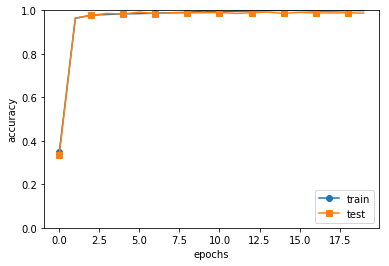

In [10]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()